In [1]:
'''
파이토치 쿠다설정
https://blog.naver.com/me_a_me/223570004477

python = 3.11.11
torch = 2.6.0
cuda = 12.4
cudnn = 9.1.0.70

pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
'''

'\n파이토치 쿠다설정\nhttps://blog.naver.com/me_a_me/223570004477\n\npython = 3.11.11\ntorch = 2.6.0\ncuda = 12.4\ncudnn = 9.1.0.70\n\npip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124\n'

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\qwer\.cache\kagglehub\datasets\birdy654\cifake-real-and-ai-generated-synthetic-images\versions\3


In [3]:
import os
import io
import cv2
import timm
import random

from PIL import Image
from tqdm.auto import tqdm  # Progress bars
from PIL import ImageFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset, random_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

c:\Users\qwer\Desktop\deepfake\.conda\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# seed 값을 설정합니다.
seed = 0

# 파이썬 seed를 고정합니다.
random.seed(seed)   

# 넘파이 seed를 고정합니다.
np.random.seed(seed)

# 파이토치 seed와 cuda, cudnn 시드를 고정합니다.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
import os

dataset_base_path = path
dataset_path_train_real = os.path.join(dataset_base_path, 'train/REAL')
dataset_path_train_fake = os.path.join(dataset_base_path, 'train/FAKE')
dataset_path_test_real = os.path.join(dataset_base_path, 'test/REAL')
dataset_path_test_fake = os.path.join(dataset_base_path, 'test/FAKE')

# 경로에서 이미지 파일 목록 가져오기
image_files_train_real = [f for f in os.listdir(dataset_path_train_real) if f.endswith(('.jpg', '.png'))]
image_files_test_real = [f for f in os.listdir(dataset_path_test_real) if f.endswith(('.jpg', '.png'))]
image_files_train_fake = [f for f in os.listdir(dataset_path_train_fake) if f.endswith(('.jpg', '.png'))]
image_files_test_fake = [f for f in os.listdir(dataset_path_test_fake) if f.endswith(('.jpg', '.png'))]

print(f"train_REAL 이미지 파일 수: {len(image_files_train_real)}")
print(f"test_REAL 이미지 파일 수: {len(image_files_test_real)}")
print(f"train_FAKE 이미지 파일 수: {len(image_files_train_fake)}")
print(f"test_FAKE 이미지 파일 수: {len(image_files_test_fake)}")

# 목록 합치기
image_files = image_files_train_real + image_files_train_fake + image_files_test_real + image_files_test_fake

print(f"이미지 파일 수: {len(image_files)}")

# 이후 코드는 image_files를 사용하여 진행
# ...

train_REAL 이미지 파일 수: 50000
test_REAL 이미지 파일 수: 10000
train_FAKE 이미지 파일 수: 50000
test_FAKE 이미지 파일 수: 10000
이미지 파일 수: 120000


In [6]:
#Dataset transformations are specified here

IMG_SIZE = 224  # Swin Transformer input size

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE), # 크기변경
    A.HorizontalFlip(p=0.5), # 좌우 뒤집기
    A.RandomBrightnessContrast(p=0.2), # 밝기와 대비 변경
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), # 정규화
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

In [7]:
#Custom dataloader
class CustomDataset(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=None)
        self.transform = transform

    def __getitem__(self, index):
        path, label = self.samples[index]
        image = Image.open(path).convert("RGB")
        image = np.array(image)
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label


In [8]:
train_dataset = CustomDataset(root=os.path.join(dataset_base_path, 'train'), transform=train_transform)
test_dataset = CustomDataset(root=os.path.join(dataset_base_path, 'test'), transform=test_transform)

# test와 validation 데이터 분리
fake_samples = [sample for sample in test_dataset.samples if sample[1] == test_dataset.class_to_idx['FAKE']]
real_samples = [sample for sample in test_dataset.samples if sample[1] == test_dataset.class_to_idx['REAL']]
# test dataset을 validation과 test로 분할 (각각 10000개) real 5000개 fake5000개
real_validation_size = 5000
fake_validation_size = 5000
real_test_size = 5000
fake_test_size  = 5000

fake_validation_dataset, fake_test_dataset = random_split(fake_samples, [fake_validation_size, fake_test_size])
real_validation_dataset, real_test_dataset = random_split(real_samples, [real_validation_size, real_test_size])

# Subset을 사용하여 데이터셋 생성
validation_samples = [fake_samples[i] for i in fake_validation_dataset.indices] + [real_samples[i] for i in real_validation_dataset.indices]
test_samples = [fake_samples[i] for i in fake_test_dataset.indices] + [real_samples[i] for i in real_test_dataset.indices]

validation_dataset = Subset(test_dataset, [test_dataset.samples.index(sample) for sample in validation_samples])
test_dataset = Subset(test_dataset, [test_dataset.samples.index(sample) for sample in test_samples])

# 빠른 테스트를 위해 1000개만 불러오기 (real과 fake데이터 비율 안맞아서 고쳐야됨)
# indices = list(range(2000))
# train_dataset = Subset(train_dataset, indices)
# validation_dataset = Subset(validation_dataset, indices)
# test_dataset = Subset(test_dataset, indices)

print(len(train_dataset))
print(len(test_dataset))
print(len(validation_dataset))

100000
10000
10000


In [9]:
# # 클래스별 데이터 개수 확인
# test_labels = [sample[1] for sample in test_dataset]
# test_class_counts = Counter(test_labels)
# validation_labels = [sample[1] for sample in validation_dataset]
# validation_class_counts = Counter(validation_labels)

# # 클래스 이름으로 출력
# class_names = ["REAL", "FAKE"]#train_dataset.classes
# test_class_counts_by_name = {class_names[label]: count for label, count in test_class_counts.items()}
# print(f"test 데이터셋 클래스별 개수: {test_class_counts_by_name}")
# validation_class_counts_by_name = {class_names[label]: count for label, count in validation_class_counts.items()}
# print(f"Validation 데이터셋 클래스별 개수: {validation_class_counts_by_name}")

In [10]:
#이미지 메모리 제한 해제
Image.MAX_IMAGE_PIXELS = None

In [11]:
class SwinClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(SwinClassifier, self).__init__()
        self.model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

# cuda check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allow loading truncated images

# Assume these variables are already defined:
# - train_dataset: your training dataset
# - test_dataset: your validation/test dataset
# - SwinClassifier: your model definition

# Set DataLoader parameters; using num_workers=0 for TPU stability
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Training hyperparameters
EPOCHS = 50 #에포크 10
PATIENCE = 100

# Define your model, loss, optimizer, and scheduler
model = SwinClassifier(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

c:\Users\qwer\Desktop\deepfake\.conda\Lib\site-packages\torch\__init__.py:2132: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


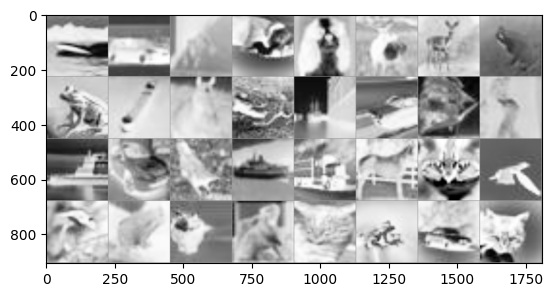

In [13]:
writer = SummaryWriter()
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# 임의의 학습 이미지를 가져옵니다
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 그리드를 만듭니다.
img_grid = torchvision.utils.make_grid(images)

# 이미지를 보여줍니다.
matplotlib_imshow(img_grid, one_channel=True)

# tensorboard에 기록합니다.
writer.add_image('images', img_grid)

writer.add_graph(model.to("cpu"), images)

In [14]:
def images_to_probs(net, images):
    '''
    학습된 신경망과 이미지 목록으로부터 예측 결과 및 확률을 생성합니다
    '''
    output = net(images).to("cpu")
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    학습된 신경망과 배치로부터 가져온 이미지 / 라벨을 사용하여 matplotlib
    Figure를 생성합니다. 이는 신경망의 예측 결과 / 확률과 함께 정답을 보여주며,
    예측 결과가 맞았는지 여부에 따라 색을 다르게 표시합니다. "images_to_probs"
    함수를 사용합니다.
    '''
    preds, probs = images_to_probs(net, images)
    # 배치에서 이미지를 가져와 예측 결과 / 정답과 함께 표시(plot)합니다
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx].to("cpu"), one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            train_dataset.classes[preds[idx]],
            probs[idx] * 100.0,
            train_dataset.classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [15]:
# Checkpoint file path
checkpoint_file = "checkpoint.pth"
# checkpoint_file = "/content/gdrive/MyDrive/best_swin_model.pth"
# Initialize or resume training variables
start_epoch = 0
if os.path.exists(checkpoint_file):
    print("Checkpoint found. Resuming training from checkpoint...")
    # Load checkpoint to CPU first, then move state to TPU
    checkpoint = torch.load(checkpoint_file, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    epochs_no_improve = checkpoint['epochs_no_improve']
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    # Move the model to the TPU device
    model.to(device)
else:
    best_val_loss = float("inf")
    epochs_no_improve = 0
    train_losses, val_losses = [], []
model.to(device)
for epoch in range(start_epoch, EPOCHS):
    model.to(device).train()
    train_loss = 0.0
    correct = 0
    total = 0
    iteration = 0

    # Training loop with a progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Training", leave=False)
    for images, labels in train_pbar:
        iteration += 1
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.long())

        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        train_loss += loss.item() * batch_size
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += batch_size

        train_pbar.set_postfix({
            "Batch Loss": f"{loss.item():.4f}",
            "Avg Loss": f"{train_loss/total:.4f}",
            "Acc": f"{correct/total:.4f}"
        })


    epoch_train_loss = train_loss / total if total > 0 else 0
    train_losses.append(epoch_train_loss)
    train_acc = correct / total if total > 0 else 0

       # ...학습 중 손실(running loss)을 기록하고
    writer.add_scalar('train loss', train_loss, epoch)
    writer.add_scalar('train acc', train_acc, epoch)
        # ...무작위 미니배치(mini-batch)에 대한 모델의 예측 결과를 보여주도록
        # Matplotlib Figure를 기록합니다
    writer.add_figure('predictions vs. actuals',
                        plot_classes_preds(model, images, labels),
                        global_step=epoch * len(train_loader))
    writer.flush()

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Validation", leave=False)
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.long())

            batch_size = images.size(0)
            val_loss += loss.item() * batch_size
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += batch_size

            val_pbar.set_postfix({
                "Batch Loss": f"{loss.item():.4f}",
                "Avg Loss": f"{val_loss/total_val:.4f}",
                "Acc": f"{correct_val/total_val:.4f}"
            })

        epoch_val_loss = val_loss / total_val if total_val > 0 else 0
        val_losses.append(epoch_val_loss)
        val_acc = correct_val / total_val if total_val > 0 else 0

        # ...학습 중 손실(running loss)을 기록하고
        writer.add_scalar('val loss', val_loss, epoch)
        writer.add_scalar('val acc', val_acc, epoch)
        writer.flush()
    
    

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save checkpoint after every epoch
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_loss': best_val_loss,
        'epochs_no_improve': epochs_no_improve,
        'train_losses': train_losses,
        'val_losses': val_losses,
    }
    torch.save(checkpoint, checkpoint_file)
    # Also save a separate model file for each epoch if desired
    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")

    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_swin_model.pth")  # Save best model separately
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered. Training stopped.")
            break

    scheduler.step()
    # print(met.metrics_report())

print("Training complete!")

Epoch 1/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 1/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/50 - Train Loss: 0.7134, Train Acc: 0.4987 | Val Loss: 0.6933, Val Acc: 0.5000


Epoch 2/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 2/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/50 - Train Loss: 0.6963, Train Acc: 0.4992 | Val Loss: 0.6940, Val Acc: 0.5000


Epoch 3/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 3/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/50 - Train Loss: 0.6970, Train Acc: 0.5006 | Val Loss: 0.6939, Val Acc: 0.5000


Epoch 4/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 4/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/50 - Train Loss: 0.6980, Train Acc: 0.5007 | Val Loss: 0.7192, Val Acc: 0.5000


Epoch 5/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 5/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/50 - Train Loss: 0.6979, Train Acc: 0.4990 | Val Loss: 0.6964, Val Acc: 0.5000


Epoch 6/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 6/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/50 - Train Loss: 0.6972, Train Acc: 0.5002 | Val Loss: 0.6951, Val Acc: 0.5000


Epoch 7/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 7/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7/50 - Train Loss: 0.6968, Train Acc: 0.5014 | Val Loss: 0.6944, Val Acc: 0.5000


Epoch 8/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 8/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8/50 - Train Loss: 0.6970, Train Acc: 0.5001 | Val Loss: 0.6933, Val Acc: 0.5000


Epoch 9/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 9/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9/50 - Train Loss: 0.6970, Train Acc: 0.5023 | Val Loss: 0.6946, Val Acc: 0.5000


Epoch 10/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 10/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10/50 - Train Loss: 0.6965, Train Acc: 0.5017 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 11/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 11/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11/50 - Train Loss: 0.6975, Train Acc: 0.5024 | Val Loss: 0.6952, Val Acc: 0.5000


Epoch 12/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 12/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12/50 - Train Loss: 0.6960, Train Acc: 0.5003 | Val Loss: 0.6948, Val Acc: 0.5000


Epoch 13/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 13/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13/50 - Train Loss: 0.6966, Train Acc: 0.5049 | Val Loss: 0.7006, Val Acc: 0.5000


Epoch 14/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 14/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14/50 - Train Loss: 0.6962, Train Acc: 0.4990 | Val Loss: 0.6957, Val Acc: 0.5000


Epoch 15/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 15/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15/50 - Train Loss: 0.6962, Train Acc: 0.5000 | Val Loss: 0.6947, Val Acc: 0.5000


Epoch 16/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 16/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16/50 - Train Loss: 0.6963, Train Acc: 0.5010 | Val Loss: 0.6933, Val Acc: 0.5000


Epoch 17/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 17/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17/50 - Train Loss: 0.6958, Train Acc: 0.4979 | Val Loss: 0.6931, Val Acc: 0.5000


Epoch 18/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 18/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18/50 - Train Loss: 0.6954, Train Acc: 0.5000 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 19/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 19/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19/50 - Train Loss: 0.6959, Train Acc: 0.5000 | Val Loss: 0.6931, Val Acc: 0.5000


Epoch 20/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 20/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20/50 - Train Loss: 0.6951, Train Acc: 0.5003 | Val Loss: 0.6965, Val Acc: 0.5000


Epoch 21/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 21/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21/50 - Train Loss: 0.6951, Train Acc: 0.5010 | Val Loss: 0.6935, Val Acc: 0.5000


Epoch 22/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 22/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22/50 - Train Loss: 0.6953, Train Acc: 0.5003 | Val Loss: 0.6933, Val Acc: 0.5000


Epoch 23/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 23/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23/50 - Train Loss: 0.6951, Train Acc: 0.4972 | Val Loss: 0.6933, Val Acc: 0.5000


Epoch 24/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 24/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24/50 - Train Loss: 0.6949, Train Acc: 0.4976 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 25/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 25/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25/50 - Train Loss: 0.6952, Train Acc: 0.5008 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 26/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 26/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26/50 - Train Loss: 0.6944, Train Acc: 0.5005 | Val Loss: 0.6933, Val Acc: 0.5000


Epoch 27/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 27/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27/50 - Train Loss: 0.6947, Train Acc: 0.4966 | Val Loss: 0.6935, Val Acc: 0.5000


Epoch 28/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 28/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28/50 - Train Loss: 0.6943, Train Acc: 0.5035 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 29/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 29/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29/50 - Train Loss: 0.6940, Train Acc: 0.4995 | Val Loss: 0.6984, Val Acc: 0.5000


Epoch 30/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 30/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30/50 - Train Loss: 0.6940, Train Acc: 0.5011 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 31/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 31/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 31/50 - Train Loss: 0.6942, Train Acc: 0.4984 | Val Loss: 0.6935, Val Acc: 0.5000


Epoch 32/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 32/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 32/50 - Train Loss: 0.6942, Train Acc: 0.4981 | Val Loss: 0.7001, Val Acc: 0.5000


Epoch 33/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 33/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 33/50 - Train Loss: 0.6936, Train Acc: 0.5027 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 34/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 34/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 34/50 - Train Loss: 0.6937, Train Acc: 0.5000 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 35/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 35/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35/50 - Train Loss: 0.6938, Train Acc: 0.4989 | Val Loss: 0.6936, Val Acc: 0.5000


Epoch 36/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 36/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 36/50 - Train Loss: 0.6935, Train Acc: 0.4996 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 37/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 37/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 37/50 - Train Loss: 0.6936, Train Acc: 0.4995 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 38/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 38/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 38/50 - Train Loss: 0.6935, Train Acc: 0.4979 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 39/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 39/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 39/50 - Train Loss: 0.6934, Train Acc: 0.5024 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 40/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 40/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40/50 - Train Loss: 0.6934, Train Acc: 0.5005 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 41/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 41/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 41/50 - Train Loss: 0.6933, Train Acc: 0.4967 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 42/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 42/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 42/50 - Train Loss: 0.6932, Train Acc: 0.5003 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 43/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 43/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 43/50 - Train Loss: 0.6932, Train Acc: 0.5001 | Val Loss: 0.6934, Val Acc: 0.5000


Epoch 44/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 44/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 44/50 - Train Loss: 0.6932, Train Acc: 0.5004 | Val Loss: 0.6931, Val Acc: 0.5000


Epoch 45/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 45/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45/50 - Train Loss: 0.6932, Train Acc: 0.4981 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 46/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 46/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 46/50 - Train Loss: 0.6932, Train Acc: 0.4979 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 47/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 47/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 47/50 - Train Loss: 0.6932, Train Acc: 0.5013 | Val Loss: 0.6933, Val Acc: 0.5000


Epoch 48/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 48/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 48/50 - Train Loss: 0.6932, Train Acc: 0.4976 | Val Loss: 0.6932, Val Acc: 0.5000


Epoch 49/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 49/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 49/50 - Train Loss: 0.6932, Train Acc: 0.4981 | Val Loss: 0.6931, Val Acc: 0.5000


Epoch 50/50 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 50/50 Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 50/50 - Train Loss: 0.6931, Train Acc: 0.4992 | Val Loss: 0.6931, Val Acc: 0.5000
Training complete!


In [16]:
torch.save(model.state_dict(), "swin_transformer_real_fake.pth")

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision import transforms
from PIL import ImageFile
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# Assume that test_dataset and your model class SwinClassifier are already defined
BATCH_SIZE = 32
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# checkpoint_path = "swin_transformer_real_fake.pth"
checkpoint_path = "best_swin_model.pth"

model = SwinClassifier(num_classes=2)  # Create an instance of your model
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
model.to(device)
model.eval()

# Define the loss function (if you want to compute test loss)
criterion = nn.CrossEntropyLoss()

# Run testing/inference
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

test_pbar = tqdm(test_loader, desc="Testing", leave=False)
with torch.no_grad():
    for images, labels in test_pbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.long())

        batch_size = images.size(0)
        test_loss += loss.item() * batch_size
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += batch_size

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        test_pbar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

avg_loss = test_loss / total if total > 0 else 0
accuracy = correct / total if total > 0 else 0

# Calculate F1 score and confusion matrix
f1 = f1_score(all_labels, all_preds, average='binary')  # or 'binary' for binary classification
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

writer.close()

Test Loss: 0.6931, Test Accuracy: 0.5000, F1 Score: 0.6667
Confusion Matrix:
[[   0 5000]
 [   0 5000]]
